**In this notebook I am trying to implement ensemble models like stacking and voting classifier on the data.**

In [ ]:
!wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/84.0.4147.105 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-GB,en-US;q=0.9,en;q=0.8" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/11835/224935/compressed/train.csv.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1597288911&Signature=TnxuH0loGUxP0ci3MkeZAQhfVvvCeUpiKCM%2FSEW2QzpP%2FtNhdZg8TVKC5TIO4YE2FVa3KV5I2sTYC7fr%2FVekk6ZOA%2BF4A2vWp8Ku%2FWyeaVmMEVCRG5ZeYEV%2FZnRcsQrJocFJPwBNt5yfXnyzw2LNuZwX7wYdEWm3mIOqnBivVNj%2BY99uZ7r7jpOmSM1qZw7yuICrpHGIA5ixn6ygb02GmMxSGQsp59UeN222orKRIwmc9lHkMbTtsgH68UJ4hBrfUj927I9oeIynNesooj6Ex41OjOtOJ2iraZShwHqU9A469BPK3rM8JmcbDvIAdCcyFacfpXFWcl8Lit0MVC6fWA%3D%3D&response-content-disposition=attachment%3B+filename%3Dtrain.csv.zip" -c -O 'train.csv.zip'

--2020-08-11 12:25:28--  https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/11835/224935/compressed/train.csv.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1597288911&Signature=TnxuH0loGUxP0ci3MkeZAQhfVvvCeUpiKCM%2FSEW2QzpP%2FtNhdZg8TVKC5TIO4YE2FVa3KV5I2sTYC7fr%2FVekk6ZOA%2BF4A2vWp8Ku%2FWyeaVmMEVCRG5ZeYEV%2FZnRcsQrJocFJPwBNt5yfXnyzw2LNuZwX7wYdEWm3mIOqnBivVNj%2BY99uZ7r7jpOmSM1qZw7yuICrpHGIA5ixn6ygb02GmMxSGQsp59UeN222orKRIwmc9lHkMbTtsgH68UJ4hBrfUj927I9oeIynNesooj6Ex41OjOtOJ2iraZShwHqU9A469BPK3rM8JmcbDvIAdCcyFacfpXFWcl8Lit0MVC6fWA%3D%3D&response-content-disposition=attachment%3B+filename%3Dtrain.csv.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.97.128, 108.177.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 456337398 (435M) [application/zip]
Saving to: ‘train.csv.zip’

train.csv.zip       1

In [ ]:
!unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


In [ ]:
import warnings
import itertools
import numpy as np 
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, log_loss
import dask.dataframe as dd
import dask
import gc

from yellowbrick.text import TSNEVisualizer

%matplotlib inline
plt.style.use("fivethirtyeight")
warnings.filterwarnings(action='ignore')
sns.set_style('whitegrid')

In [ ]:
# This is to be used for memory optimization because the data is very large.
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
              df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df
def featureModify(isTrain, numRows):
    if isTrain:
        df = dd.read_csv('train.csv',nrows=numRows) 
        df = df.compute()
        # df['pilot'] = 100*df['crew']+df['seat']
        df = reduce_mem_usage(df)
        df['event'] = df['event'].map({
            'A':0,
            'B':1,
            'C':2,
            'D':3
        })
    else:
        df = dd.read_csv('test.csv',nrows=numRows)
        df = df.compute()
        # df['pilot'] = 100*df['crew']+df['seat']
        df = reduce_mem_usage(df)
    
    return df 
train = featureModify(True, None)
y = train['event']
train = train.drop('event',axis=1)
print(train.shape)
print(train.columns)

Memory usage of dataframe is 1076.93 MB
Memory usage after optimization is: 278.52 MB
Decreased by 74.1%
(4867421, 27)
Index(['crew', 'experiment', 'time', 'seat', 'eeg_fp1', 'eeg_f7', 'eeg_f8',
       'eeg_t4', 'eeg_t6', 'eeg_t5', 'eeg_t3', 'eeg_fp2', 'eeg_o1', 'eeg_p3',
       'eeg_pz', 'eeg_f3', 'eeg_fz', 'eeg_f4', 'eeg_c4', 'eeg_p4', 'eeg_poz',
       'eeg_c3', 'eeg_cz', 'eeg_o2', 'ecg', 'r', 'gsr'],
      dtype='object')


In [ ]:
train.head()

,crew,experiment,time,seat,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,eeg_t3,eeg_fp2,eeg_o1,eeg_p3,eeg_pz,eeg_f3,eeg_fz,eeg_f4,eeg_c4,eeg_p4,eeg_poz,eeg_c3,eeg_cz,eeg_o2,ecg,r,gsr
0,1,CA,0.011719,1,-5.285156,26.781250,-9.523438,-12.796875,16.718750,33.75000,23.718750,-6.695312,29.234375,24.843750,3.921875,18.453125,1.075195,3.089844,37.375000,17.437500,19.203125,20.593750,-3.951172,14.507812,-4520.0,817.5,388.75
1,1,CA,0.015625,1,-2.427734,28.437500,-9.320312,-3.757812,15.968750,30.43750,21.015625,-6.476562,26.640625,24.140625,5.468750,20.515625,2.833984,7.101562,31.171875,19.406250,19.687500,21.359375,1.332031,17.750000,-4520.0,817.5,388.75
2,1,CA,0.019531,1,10.671875,30.421875,15.351562,24.718750,16.140625,32.15625,25.437500,-0.088684,28.125000,26.890625,8.578125,23.156250,4.519531,12.703125,-12.015625,19.390625,23.171875,22.406250,1.538086,22.250000,-4520.0,817.5,388.75
3,1,CA,0.023438,1,11.453125,25.609375,2.433594,12.414062,20.531250,31.50000,19.140625,-0.256592,30.656250,24.250000,8.640625,19.968750,7.277344,11.460938,18.578125,23.156250,22.640625,19.343750,2.544922,19.000000,-4520.0,817.5,388.75
4,1,CA,0.027344,1,7.285156,25.937500,0.113586,5.746094,19.828125,28.75000,20.578125,-1.953125,31.718750,25.156250,12.500000,18.750000,7.308594,8.007812,6.554688,22.750000,22.671875,20.296875,1.699219,22.812500,-4520.0,817.5,388.75


In [ ]:
train.columns

Index(['crew', 'experiment', 'time', 'seat', 'eeg_fp1', 'eeg_f7', 'eeg_f8',
       'eeg_t4', 'eeg_t6', 'eeg_t5', 'eeg_t3', 'eeg_fp2', 'eeg_o1', 'eeg_p3',
       'eeg_pz', 'eeg_f3', 'eeg_fz', 'eeg_f4', 'eeg_c4', 'eeg_p4', 'eeg_poz',
       'eeg_c3', 'eeg_cz', 'eeg_o2', 'ecg', 'r', 'gsr'],
      dtype='object')

In [ ]:
feature = ['eeg_fp1', 'eeg_f7', 'eeg_f8',
       'eeg_t4', 'eeg_t6', 'eeg_t5', 'eeg_t3', 'eeg_fp2', 'eeg_o1', 'eeg_p3',
       'eeg_pz', 'eeg_f3', 'eeg_fz', 'eeg_f4', 'eeg_c4', 'eeg_p4', 'eeg_poz',
       'eeg_c3', 'eeg_cz', 'eeg_o2', 'ecg', 'r', 'gsr']

In [ ]:
from sklearn.preprocessing import MinMaxScaler
mn = MinMaxScaler()
for i in feature:
  train[i] = mn.fit_transform(np.array(train[i]).reshape(-1,1))

In [ ]:
train.head()

,crew,experiment,time,seat,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,eeg_t3,eeg_fp2,eeg_o1,eeg_p3,eeg_pz,eeg_f3,eeg_fz,eeg_f4,eeg_c4,eeg_p4,eeg_poz,eeg_c3,eeg_cz,eeg_o2,ecg,r,gsr
0,1,CA,0.011719,1,0.406738,0.443115,0.431396,0.463135,0.583496,0.531738,0.466309,0.396484,0.611816,0.580566,0.571289,0.501465,0.510742,0.534668,0.593262,0.583496,0.468506,0.580078,0.528809,0.328857,0.266602,0.9375,0.194458
1,1,CA,0.015625,1,0.407715,0.443604,0.431396,0.465820,0.583008,0.530273,0.465332,0.396484,0.610840,0.580078,0.571289,0.502441,0.511230,0.535645,0.590332,0.584473,0.468506,0.580078,0.532715,0.329834,0.266602,0.9375,0.194458
2,1,CA,0.019531,1,0.411621,0.444092,0.437988,0.474609,0.583496,0.531250,0.466797,0.398438,0.611328,0.581543,0.571777,0.503418,0.511230,0.537109,0.569824,0.584473,0.469971,0.580566,0.532715,0.331055,0.266602,0.9375,0.194458
3,1,CA,0.023438,1,0.411865,0.442871,0.434570,0.470947,0.585449,0.530762,0.464600,0.398438,0.611816,0.580078,0.572266,0.501953,0.511719,0.536621,0.584473,0.585938,0.469727,0.579102,0.533691,0.330078,0.266602,0.9375,0.194458
4,1,CA,0.027344,1,0.410645,0.442871,0.433838,0.468750,0.584961,0.529785,0.465088,0.397949,0.612305,0.580566,0.572754,0.501953,0.511719,0.536133,0.578613,0.585938,0.469727,0.579590,0.533203,0.331299,0.266602,0.9375,0.194458


In [ ]:
dic1 = {'CA':0,'DA':1,'SS':3,'LOFT':4}
train['experiment'] = train['experiment'].apply(lambda x: dic1[x])
train['experiment'] = train['experiment'].astype('int8')

In [ ]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB 
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn import model_selection
from mlxtend.classifier import EnsembleVoteClassifier
from sklearn.metrics import log_loss


# **Voting Classifier**

**A Voting Classifier is a machine learning model that trains on an ensemble of numerous models and predicts an output (class) based on their highest probability of chosen class as the output.**

In [ ]:
clf1 = LogisticRegression(random_state=1, C=0.01)
clf2 = RandomForestClassifier(random_state=1,n_estimators = 50, max_depth = 200, criterion = 'entropy')
clf3 = MultinomialNB(alpha=1e-07)
clf4 = DecisionTreeClassifier(max_depth =200, criterion = 'entropy', random_state =40)
clf5 = LGBMClassifier(    objective='multiclass',
                          metric='multi_error',
                          num_class=4,
                          num_leaves=30,
                          learning_rate = 0.01,
                          num_threads=4,
                          colsample_bytree=0.5,
                          min_data_in_leaf=100, 
                          min_split_gain=0.00019,
                          bagging_fraction = 0.9,
                          bagging_seed=0)

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(train,y,test_size=0.25,random_state=40)

In [ ]:
eclf1 = VotingClassifier(estimators=[('lgb',clf5), ('mnb', clf3), ('rf', clf2), ('lr', clf1), ('DT',clf4)], voting='soft')
eclf1.fit(X_train,y_train)

VotingClassifier(estimators=[('lgb',
                              LGBMClassifier(bagging_fraction=0.9,
                                             bagging_seed=0,
                                             boosting_type='gbdt',
                                             class_weight=None,
                                             colsample_bytree=0.5,
                                             importance_type='split',
                                             learning_rate=0.01, max_depth=-1,
                                             metric='multi_error',
                                             min_child_samples=20,
                                             min_child_weight=0.001,
                                             min_data_in_leaf=100,
                                             min_split_gain=0.00019,
                                             n_estimators=100, n_jobs=-1,
                                             num_class=4...
               

In [ ]:
import os
os.chdir('/content/drive/My Drive/ML case study/models')

In [ ]:
import joblib
joblib.dump(eclf1,'voting_classifier(1).pkl')

['voting_classifier(1).pkl']

In [ ]:
y_pred = eclf1.predict_proba(X_test)

In [ ]:
y_pred

array([[0.92994889, 0.03118097, 0.03171215, 0.00715799],
       [0.09489309, 0.00410205, 0.88611002, 0.01489484],
       [0.07022134, 0.00356289, 0.91097268, 0.01524309],
       ...,
       [0.86321356, 0.0312255 , 0.04371111, 0.06184983],
       [0.08433996, 0.00370177, 0.89485315, 0.01710512],
       [0.92420922, 0.02859831, 0.03546824, 0.01172423]])

In [ ]:
log_loss(y_test,y_pred)

0.17574586453615432

In [ ]:
import joblib
model = joblib.load('/content/drive/My Drive/ML case study/models/voting_classifier(1).pkl')

In [ ]:
model

VotingClassifier(estimators=[('lgb',
                              LGBMClassifier(bagging_fraction=0.9,
                                             bagging_seed=0,
                                             boosting_type='gbdt',
                                             class_weight=None,
                                             colsample_bytree=0.5,
                                             importance_type='split',
                                             learning_rate=0.01, max_depth=-1,
                                             metric='multi_error',
                                             min_child_samples=20,
                                             min_child_weight=0.001,
                                             min_data_in_leaf=100,
                                             min_split_gain=0.00019,
                                             n_estimators=100, n_jobs=-1,
                                             num_class=4...
               

In [ ]:
os.chdir('/content')

In [ ]:
!wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/84.0.4147.105 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-GB,en-US;q=0.9,en;q=0.8" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/11835/224935/compressed/test.csv.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1597317006&Signature=RFZIgHU2QfPyXomx2CB0mTu0SAWvD89f1Gjd9tgjN1vLYho2Bstu6SoTu%2BkzFXrPuuuJtfYTQs%2BgQIO2kthGiViz%2BvIKCN02zjTG6VsBCpfIbbMS2csp5LYN3GGOp1XvfpT2FbTVf9HMczleZF%2BIPzD1GEIJi75oWVvUb3BD5o1hHrSsRm0t%2F1fv8c%2FozoRAOOtrN8QxUg9xezjW7TdVTQOey7WZao6SF4IUMNQNwqvz4%2BdOlLcE%2BMiQQN45UV7APiFtlsMpN%2Bz%2F2bFx%2F%2Fb%2FCxt00rmHlIuuQoxzd8znJAfA9SxxOVHaC4Z0eHIATvWGD%2FoyuEqiA1khMz11uwpSOA%3D%3D&response-content-disposition=attachment%3B+filename%3Dtest.csv.zip" -c -O 'test.csv.zip'

--2020-08-11 12:26:50--  https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/11835/224935/compressed/test.csv.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1597317006&Signature=RFZIgHU2QfPyXomx2CB0mTu0SAWvD89f1Gjd9tgjN1vLYho2Bstu6SoTu%2BkzFXrPuuuJtfYTQs%2BgQIO2kthGiViz%2BvIKCN02zjTG6VsBCpfIbbMS2csp5LYN3GGOp1XvfpT2FbTVf9HMczleZF%2BIPzD1GEIJi75oWVvUb3BD5o1hHrSsRm0t%2F1fv8c%2FozoRAOOtrN8QxUg9xezjW7TdVTQOey7WZao6SF4IUMNQNwqvz4%2BdOlLcE%2BMiQQN45UV7APiFtlsMpN%2Bz%2F2bFx%2F%2Fb%2FCxt00rmHlIuuQoxzd8znJAfA9SxxOVHaC4Z0eHIATvWGD%2FoyuEqiA1khMz11uwpSOA%3D%3D&response-content-disposition=attachment%3B+filename%3Dtest.csv.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.203.128, 64.233.188.128, 64.233.189.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1791131386 (1.7G) [application/zip]
Saving to: ‘test.csv.zip’

test.csv.z

In [ ]:
!unzip test.csv.zip

Archive:  test.csv.zip
  inflating: test.csv                


In [ ]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB 
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn import model_selection
from mlxtend.classifier import EnsembleVoteClassifier
from sklearn.metrics import log_loss


In [ ]:
test = featureModify(False,None)
print('Done Test Read')

Memory usage of dataframe is 3974.83 MB
Memory usage after optimization is: 1079.37 MB
Decreased by 72.8%
Done Test Read


In [ ]:
test.head()

,id,crew,experiment,time,seat,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,eeg_t3,eeg_fp2,eeg_o1,eeg_p3,eeg_pz,eeg_f3,eeg_fz,eeg_f4,eeg_c4,eeg_p4,eeg_poz,eeg_c3,eeg_cz,eeg_o2,ecg,r,gsr
0,0,1,LOFT,0.000000,0,17.906250,6.128906,0.994629,-28.203125,-47.687500,-187.125000,-33.187500,-4.222656,8.179688,33.156250,33.812500,21.750000,16.296875,-7.042969,-14.406250,-4.035156,-0.393799,31.843750,17.078125,-8.140625,-7324.0,643.0,595.00
1,1,1,LOFT,0.000000,1,45.875000,94.750000,23.296875,1.391602,2.060547,-5.144531,6.394531,33.406250,-295.000000,8.375000,29.640625,16.218750,850.500000,19.890625,-215.125000,2.119141,7.339844,9.664062,1169.000000,-0.024414,-3336.0,826.5,136.25
2,2,1,LOFT,0.003906,0,33.125000,28.359375,-7.238281,-7.691406,-25.828125,-107.250000,12.843750,1.214844,13.320312,44.437500,37.593750,29.078125,22.312500,-7.640625,-10.367188,10.953125,6.511719,36.031250,24.359375,0.956055,-7324.0,643.0,595.00
3,3,1,LOFT,0.003906,1,43.281250,95.875000,18.703125,-1.432617,-4.234375,-8.023438,7.425781,27.343750,-310.250000,5.390625,27.734375,7.218750,816.500000,13.828125,-214.250000,-4.914062,3.503906,3.878906,1159.000000,-0.047607,-3336.0,826.5,136.25
4,4,1,LOFT,0.007812,0,7.929688,3.460938,-10.859375,-26.359375,-25.890625,37.000000,-50.343750,-11.679688,-1.143555,-17.593750,34.062500,22.906250,19.031250,2.044922,-20.781250,-3.613281,-7.539062,3.083984,13.648438,1.473633,-7324.0,643.0,595.00


In [ ]:
df_sub = pd.DataFrame()
df_sub['id'] = test['id']
test = test.drop('id',axis=1)

In [ ]:
feature = ['eeg_fp1', 'eeg_f7', 'eeg_f8',
       'eeg_t4', 'eeg_t6', 'eeg_t5', 'eeg_t3', 'eeg_fp2', 'eeg_o1', 'eeg_p3',
       'eeg_pz', 'eeg_f3', 'eeg_fz', 'eeg_f4', 'eeg_c4', 'eeg_p4', 'eeg_poz',
       'eeg_c3', 'eeg_cz', 'eeg_o2', 'ecg', 'r', 'gsr']

In [ ]:
from sklearn.preprocessing import MinMaxScaler
mn = MinMaxScaler()
for i in feature:
  test[i] = mn.fit_transform(np.array(test[i]).reshape(-1,1))

In [ ]:
test.head()

,crew,experiment,time,seat,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,eeg_t3,eeg_fp2,eeg_o1,eeg_p3,eeg_pz,eeg_f3,eeg_fz,eeg_f4,eeg_c4,eeg_p4,eeg_poz,eeg_c3,eeg_cz,eeg_o2,ecg,r,gsr
0,1,LOFT,0.000000,0,0.495361,0.500488,0.493164,0.491699,0.489258,0.475342,0.491455,0.494629,0.501465,0.498291,0.502930,0.498291,0.500488,0.494141,0.507812,0.494873,0.494385,0.498779,0.510254,0.518066,0.0,0.575195,0.297607
1,1,LOFT,0.000000,1,0.498291,0.509766,0.495605,0.494873,0.494629,0.494873,0.495605,0.498779,0.467285,0.495605,0.502441,0.497559,0.592285,0.497070,0.485596,0.495605,0.495117,0.496338,0.649414,0.519043,0.0,0.991211,0.068176
2,1,LOFT,0.003906,0,0.496826,0.502930,0.492432,0.493896,0.491699,0.483887,0.496338,0.495361,0.501953,0.499268,0.502930,0.499023,0.501465,0.494141,0.508301,0.496582,0.495117,0.499268,0.511230,0.519043,0.0,0.575195,0.297607
3,1,LOFT,0.003906,1,0.498047,0.510254,0.495117,0.494385,0.493896,0.494385,0.495605,0.498047,0.465332,0.495117,0.501953,0.496582,0.588379,0.496338,0.485840,0.494873,0.494873,0.495850,0.648438,0.519043,0.0,0.991211,0.068176
4,1,LOFT,0.007812,0,0.494141,0.500000,0.491943,0.491699,0.491699,0.499268,0.489502,0.493896,0.500488,0.492676,0.502930,0.498291,0.500977,0.495117,0.506836,0.494873,0.493652,0.495605,0.509766,0.519043,0.0,0.575195,0.297607


In [ ]:
dic1 = {'CA':0,'DA':1,'SS':3,'LOFT':4}
test['experiment'] = test['experiment'].apply(lambda x: dic1[x])
test['experiment'] = test['experiment'].astype('int8')

In [ ]:
y_pred = model.predict_proba(test)

In [ ]:
y_pred

array([[0.85903671, 0.05541984, 0.07509567, 0.01044778],
       [0.87725464, 0.04538119, 0.05571262, 0.02165154],
       [0.85904952, 0.0554075 , 0.07509567, 0.01044731],
       ...,
       [0.68104471, 0.00780678, 0.07783888, 0.23330963],
       [0.72996542, 0.01540105, 0.04099227, 0.21364126],
       [0.68104448, 0.00780678, 0.07783888, 0.23330986]])

In [ ]:
import os
os.chdir('/content/drive/My Drive/ML case study/results')

In [ ]:
df_sub = pd.DataFrame(np.concatenate((np.arange(len(test))[:, np.newaxis], y_pred), axis=1), columns=['id', 'A', 'B', 'C', 'D'])
df_sub['id'] = df_sub['id'].astype(int)
print(df_sub)
df_sub.to_csv("Model_building5_LGBop.csv", index=False)

                id         A         B         C         D
0                0  0.859037  0.055420  0.075096  0.010448
1                1  0.877255  0.045381  0.055713  0.021652
2                2  0.859050  0.055408  0.075096  0.010447
3                3  0.881251  0.045385  0.055713  0.017652
4                4  0.859043  0.055414  0.075096  0.010448
...            ...       ...       ...       ...       ...
17965138  17965138  0.677046  0.011807  0.077839  0.233308
17965139  17965139  0.729966  0.015401  0.040992  0.213640
17965140  17965140  0.681045  0.007807  0.077839  0.233310
17965141  17965141  0.729965  0.015401  0.040992  0.213641
17965142  17965142  0.681044  0.007807  0.077839  0.233310

[17965143 rows x 5 columns]


# **Stacking Classifier**

**Stacked generalization consists in stacking the output of individual estimator and use a classifier to compute the final prediction. Stacking allows to use the strength of each individual estimator by using their output as input of a final estimator.**

In [ ]:
from sklearn.ensemble import StackingClassifier
clf1 = LogisticRegression(random_state=1, C=0.01)
clf2 = RandomForestClassifier(random_state=1,n_estimators = 10, max_depth = 200, criterion = 'entropy')
clf3 = MultinomialNB(alpha=1e-07)
clf4 = DecisionTreeClassifier(max_depth =200, criterion = 'entropy', random_state =40)
clf5 = LGBMClassifier(    objective='multiclass',
                          metric='multi_error',
                          num_class=4,
                          num_leaves=30,
                          learning_rate = 0.01,
                          num_threads=4,
                          colsample_bytree=0.5,
                          min_data_in_leaf=100, 
                          min_split_gain=0.00019,
                          bagging_fraction = 0.9,
                          bagging_seed=0)

In [ ]:
estimators = [
     ('dt', clf4),
     ('lgb', clf5),
     ('rf',clf2)
              ]

In [ ]:
clf = StackingClassifier(estimators=estimators,stack_method='auto',verbose=500,cv=2)
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(train,y,test_size=0.2,random_state=40)

In [ ]:
clf.fit(X_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   31.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  6.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  6.1min finished


StackingClassifier(cv=2,
                   estimators=[('dt',
                                DecisionTreeClassifier(ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='entropy',
                                                       max_depth=200,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort='deprecated',
                      

In [ ]:
y_pred = clf.predict_proba(X_test)
print(y_pred)
from sklearn.metrics import log_loss
print(log_loss(y_test,y_pred))

NameError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/My Drive/ML case study/models')

In [ ]:
import joblib
joblib.dump(clf,'stacking_classifer(1).pkl')

['stacking_classifer(1).pkl']

In [ ]:
import joblib
clf = joblib.load('stacking_classifer(1).pkl')

In [ ]:
y_pred = clf.predict_proba(test)

In [ ]:
y_pred

array([[9.99599839e-01, 8.83706626e-05, 2.31596274e-05, 2.88630510e-04],
       [9.99805754e-01, 3.91820473e-05, 2.99227209e-06, 1.52071679e-04],
       [9.99599839e-01, 8.83706626e-05, 2.31596274e-05, 2.88630510e-04],
       ...,
       [9.98276114e-01, 6.54340388e-04, 3.15275662e-04, 7.54269753e-04],
       [9.99062115e-01, 5.57535162e-04, 1.59893688e-05, 3.64360467e-04],
       [9.98276114e-01, 6.54340388e-04, 3.15275662e-04, 7.54269753e-04]])

In [ ]:
os.chdir('/content/drive/My Drive/ML case study/results')

In [ ]:
df_sub = pd.DataFrame(np.concatenate((np.arange(len(test))[:, np.newaxis], y_pred), axis=1), columns=['id', 'A', 'B', 'C', 'D'])
df_sub['id'] = df_sub['id'].astype(int)
print(df_sub)
df_sub.to_csv("stacking_op(1).csv", index=False)

                id         A         B         C         D
0                0  0.999600  0.000088  0.000023  0.000289
1                1  0.999806  0.000039  0.000003  0.000152
2                2  0.999600  0.000088  0.000023  0.000289
3                3  0.999806  0.000039  0.000003  0.000152
4                4  0.999600  0.000088  0.000023  0.000289
...            ...       ...       ...       ...       ...
17965138  17965138  0.998276  0.000654  0.000315  0.000754
17965139  17965139  0.999062  0.000558  0.000016  0.000364
17965140  17965140  0.998276  0.000654  0.000315  0.000754
17965141  17965141  0.999062  0.000558  0.000016  0.000364
17965142  17965142  0.998276  0.000654  0.000315  0.000754

[17965143 rows x 5 columns]


In [ ]:
y_pred.shape

(17965143, 4)

The results on kaggle submission are as follows 
For voting classifier I got public scre of 0.463 and private score of 0.73.
For stacking classifier I got the public score of 0.63 and private score of 1.408.

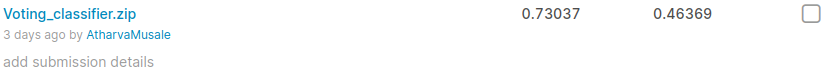

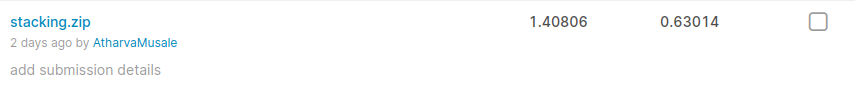